In [8]:
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,image,classes
0,0,image/0.jpeg,unknown
1,1,image/1.jpeg,head_lamp
2,2,image/2.jpeg,door_scratch
3,3,image/3.jpeg,head_lamp
4,4,image/4.jpeg,unknown


In [16]:
# Drop 'Unnamed: 0'
data.drop(['Unnamed: 0'], axis=1, inplace=True)

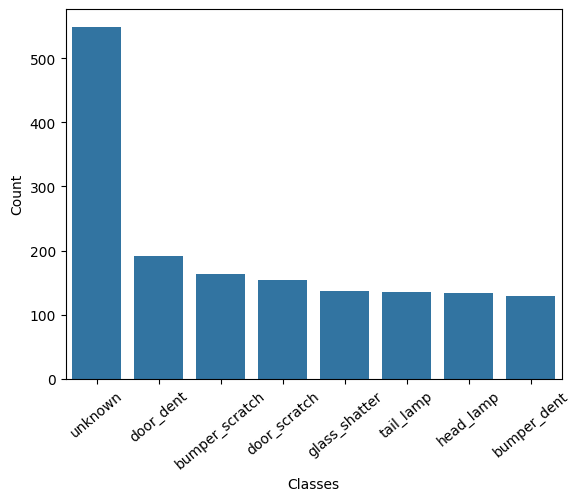

In [17]:
counts = data['classes'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=40);

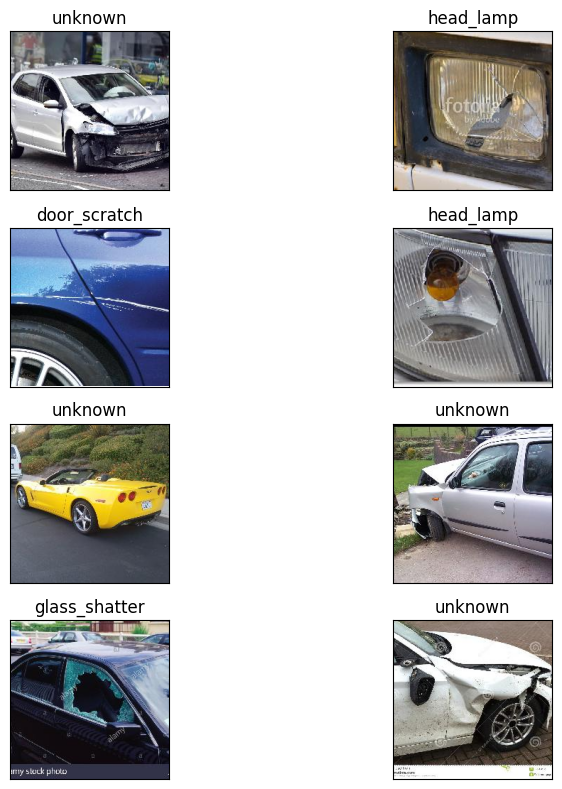

In [18]:
datafig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.image[i]))
    ax.set_title(data.classes[i])
plt.tight_layout()
plt.show()

In [19]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [20]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [21]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=0,
    subset='validation'
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1020 validated image filenames belonging to 8 classes.
Found 255 validated image filenames belonging to 8 classes.
Found 319 validated image filenames belonging to 8 classes.


In [22]:
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [11]:
inputs = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [14]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

Epoch 1/50


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 379ms/step - accuracy: 0.4231 - loss: 1.6615 - val_accuracy: 0.6549 - val_loss: 0.9139
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.8081 - loss: 0.6299 - val_accuracy: 0.7647 - val_loss: 0.7042
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.8899 - loss: 0.3643 - val_accuracy: 0.7961 - val_loss: 0.6274
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.9335 - loss: 0.2537 - val_accuracy: 0.7843 - val_loss: 0.6988
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.9694 - loss: 0.1429 - val_accuracy: 0.7843 - val_loss: 0.6596


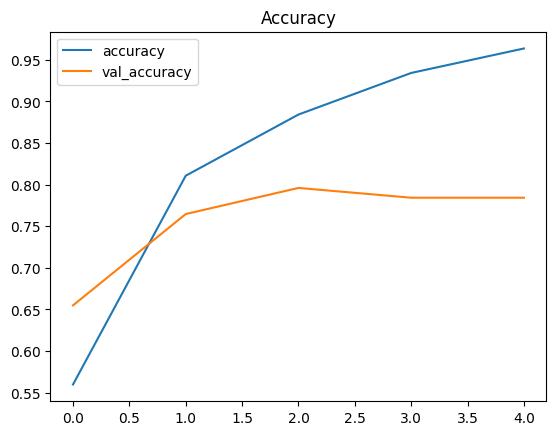

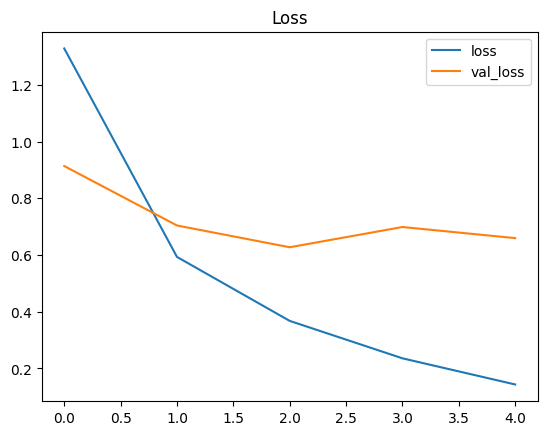

In [15]:
# Plotting Accuracy and val_accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plotting loss and val_loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
# Calculating Test Accuracy and Loss
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.68792
Test Accuracy: 76.49%


In [17]:
pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step


In [18]:

y_test = list(test_df.classes)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

   bumper_dent       0.41      0.57      0.48        21
bumper_scratch       0.97      0.86      0.91        43
     door_dent       0.62      0.57      0.60        35
  door_scratch       0.62      0.62      0.62        29
 glass_shatter       0.83      0.71      0.77        21
     head_lamp       0.63      0.76      0.69        25
     tail_lamp       0.64      0.74      0.69        31
       unknown       0.93      0.88      0.90       114

      accuracy                           0.76       319
     macro avg       0.71      0.71      0.71       319
  weighted avg       0.78      0.76      0.77       319



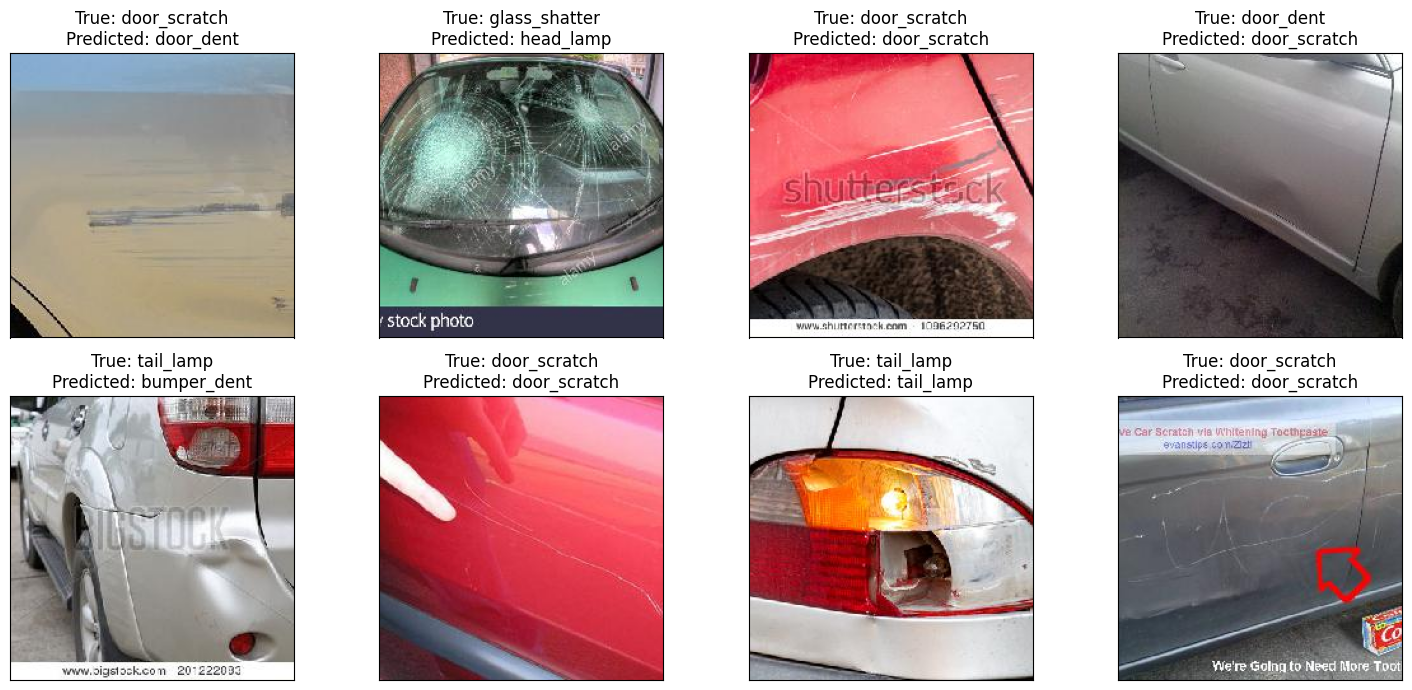

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.classes.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

VGG16 Model

In [21]:
pretrained_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [22]:
inputs = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [25]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3388 - loss: 1.8675 - val_accuracy: 0.4706 - val_loss: 1.5379
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4688 - loss: 1.4630 - val_accuracy: 0.6353 - val_loss: 1.1715
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6082 - loss: 1.1760 - val_accuracy: 0.6431 - val_loss: 1.0362
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7024 - loss: 0.9416 - val_accuracy: 0.6706 - val_loss: 0.9203
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7179 - loss: 0.8254 - val_accuracy: 0.6824 - val_loss: 0.8822
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7524 - loss: 0.7385 - val_accuracy: 0.6667 - val_loss: 0.8523
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7837 - loss: 0.6639 - val_accuracy: 0.7569 - val_loss: 0.6901
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7844 - loss: 0.6439 - val_accuracy: 0.6980 - val_loss:

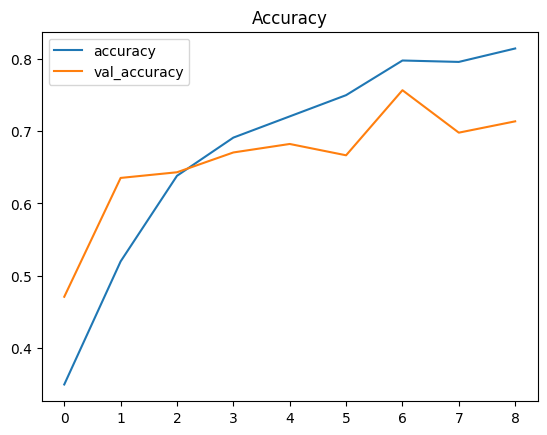

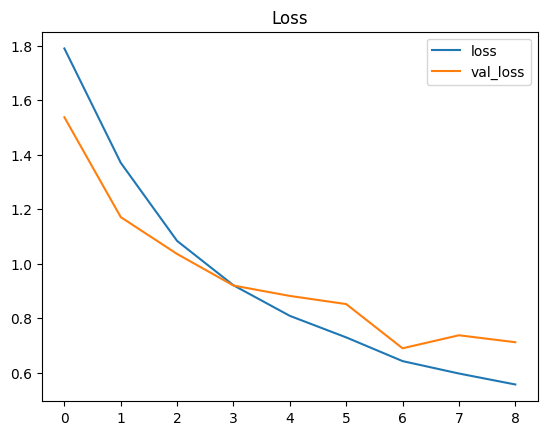

In [26]:
# Plotting Accuracy and val_accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plotting loss and val_loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [27]:
pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [28]:

y_test = list(test_df.classes)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

   bumper_dent       0.69      0.52      0.59        21
bumper_scratch       0.83      0.47      0.60        43
     door_dent       0.79      0.54      0.64        35
  door_scratch       0.51      0.79      0.62        29
 glass_shatter       0.71      0.81      0.76        21
     head_lamp       0.63      0.68      0.65        25
     tail_lamp       0.63      0.77      0.70        31
       unknown       0.85      0.90      0.88       114

      accuracy                           0.73       319
     macro avg       0.71      0.69      0.68       319
  weighted avg       0.75      0.73      0.73       319



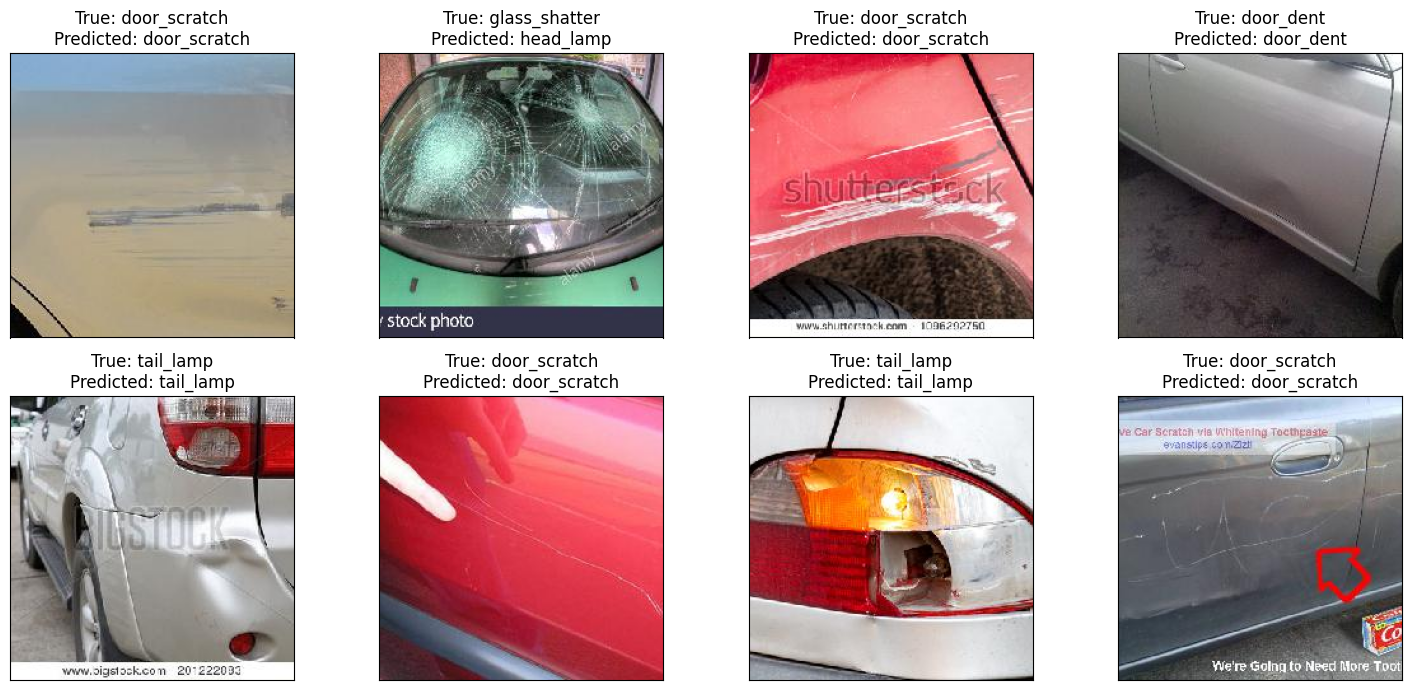

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.classes.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [2]:
# Importing libraries
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(8, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
 model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,992 (42.61 MB)

 Trainable params: 11,169,992 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [24]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

Epoch 1/50


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.2679 - loss: 2.7202 - val_accuracy: 0.3569 - val_loss: 1.7922
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.3890 - loss: 1.7002 - val_accuracy: 0.4118 - val_loss: 1.6090
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.4897 - loss: 1.3807 - val_accuracy: 0.4549 - val_loss: 1.5837
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.5855 - loss: 1.1791 - val_accuracy: 0.5137 - val_loss: 1.5360
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.7401 - loss: 0.7940 - val_accuracy: 0.5608 - val_loss: 1.4543
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.8151 - loss: 0.5881 - val_accuracy: 0.5373 - val_loss: 1.6958
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.8217 - loss: 0.4913 - val_accuracy: 0.5490 - val_loss: 1.8285


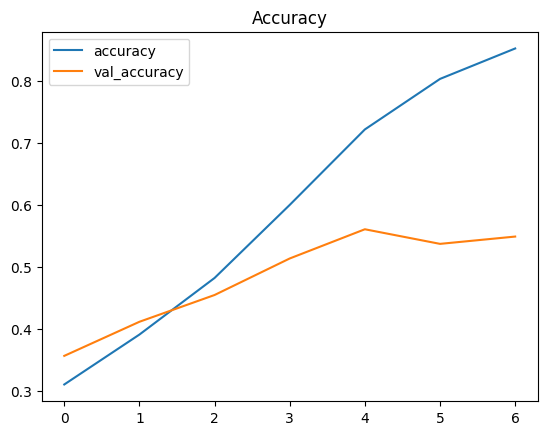

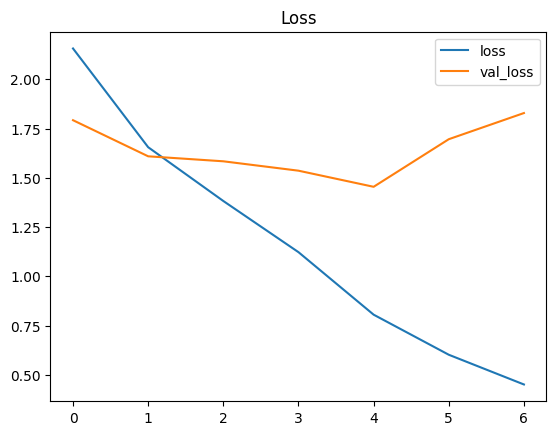

In [28]:
# Plotting Accuracy and val_accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plotting loss and val_loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [25]:
pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


In [26]:

y_test = list(test_df.classes)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

   bumper_dent       0.38      0.32      0.35        25
bumper_scratch       0.74      0.48      0.58        29
     door_dent       0.43      0.18      0.25        50
  door_scratch       0.34      0.46      0.39        28
 glass_shatter       0.75      0.52      0.61        29
     head_lamp       0.38      0.42      0.40        24
     tail_lamp       0.48      0.45      0.47        22
       unknown       0.64      0.88      0.74       112

      accuracy                           0.55       319
     macro avg       0.52      0.46      0.47       319
  weighted avg       0.55      0.55      0.53       319



In [27]:
# Calculating Test Accuracy and Loss
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.75536
Test Accuracy: 55.49%
